# Mixing Score
The purpose of this notebook is to calculate the mixing score of a sample. Defined originally as a way to quantify the degree of mixing between specifically tumor and immune cells [(Keren et al , Cell 2018)](https://www.cell.com/cell/fulltext/S0092-8674(18)31100-0), the mixing score below has been adapted to analyze any two cell populations provided.

In [ ]:
import os
import seaborn
import pandas as pd

import ark.settings as settings
from ark.analysis.spatial_analysis import compute_cell_neighbors, compute_mixing_score, create_neighborhood_matrix, compute_cell_ratios
from ark.utils import spatial_analysis_utils, example_dataset
from tmi import misc_utils

## 0. Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook, as well as the data previously generated by segmentation and cell clustering.

In [ ]:
base_dir = '../data/example_dataset'

If you would like to first try running this notebook with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

In [ ]:
example_dataset.get_example_dataset(dataset="post_clustering", save_dir = base_dir, overwrite_existing = True)

## 1. Set Up
### Define paths
* `cell_table_path`: the path to the cell table that contains columns for fov, cell label, and cell phenotype (generated from `3_Cluster_Cells.ipynb`)
* `segmentation_dir`: the path to the directory containing your segmentations (generated from 1_Segment_Image_Data.ipynb)
* `dist_mat_dir`: the path to directory containing the distance matrices for each FOV, if not previously generated by either [example_neighborhood_analysis_script.ipynb](./example_neighborhood_analysis_script.ipynb) or [example_pairwise_spatial_enrichment.ipynb](./example_pairwise_spatial_enrichment.ipynb), a new directory will be created below

In [ ]:
cell_table_path = os.path.join(base_dir, "segmentation/cell_table/cell_table_size_normalized_cell_labels.csv")
segmentation_dir = os.path.join(base_dir, "segmentation/deepcell_output")
dist_mat_dir = os.path.join(base_dir, "spatial_analysis/dist_mats")

# new directories
mixing_score_dir = os.path.join(base_dir, "mixing_score")
cell_neighbors_dir = os.path.join(mixing_score_dir, "cell_neighbors")

In [ ]:
# create output directory
if not os.path.exists(cell_neighbors_dir):
    os.makedirs(cell_neighbors_dir)

# create the dist_mat_output directory if it doesn't exist
if not os.path.exists(dist_mat_dir):
    os.makedirs(dist_mat_dir)
    spatial_analysis_utils.calc_dist_matrix(segmentation_dir, dist_mat_dir)
    
# create mixing directory
if not os.path.exists(mixing_score_dir):
    os.makedirs(mixing_score_dir)

### Read in data from the cell table

In [ ]:
all_data = pd.read_csv(cell_table_path)
all_fovs = all_data[settings.FOV_ID].unique()

### Define cell populations of interest and compute neighbors matrices
The neighbors matrix for each FOV will be saved as individual files in the the `cell_neighbors_dir`.
- `pixel_radius`: radius used to define the neighbors of each cell

In [ ]:
pixel_radius = 100
compute_cell_neighbors(all_data, dist_mat_dir, cell_neighbors_dir, neighbors_radius=pixel_radius)

## 2. Examine ratio of cell populations

When quanifying the amount of mixing in a sample, having a much higher presence of cells from one population compared to the other can produce a misleading score.  Looking at the ratios of cell populations below will help with determining limits for each population, so that any samples with ratios above the specified threshold will not be assigned a mixing score.
- `population_1_cells`: list of cells types belonging to the first population
- `population_2_cells`: list of cells types belonging to the second population
- `bins`: number of bins for the histogram, you may adjust this variable and rerun the below cells if necessary

### Examine the plots produced to identify a threshold that will exclude outliers and extremely high values. Samples with a zero cell count for either population are automatically excluded.

In [ ]:
population_1_cells = ['CD4T']
population_2_cells = ['CD8T']

bins = 30

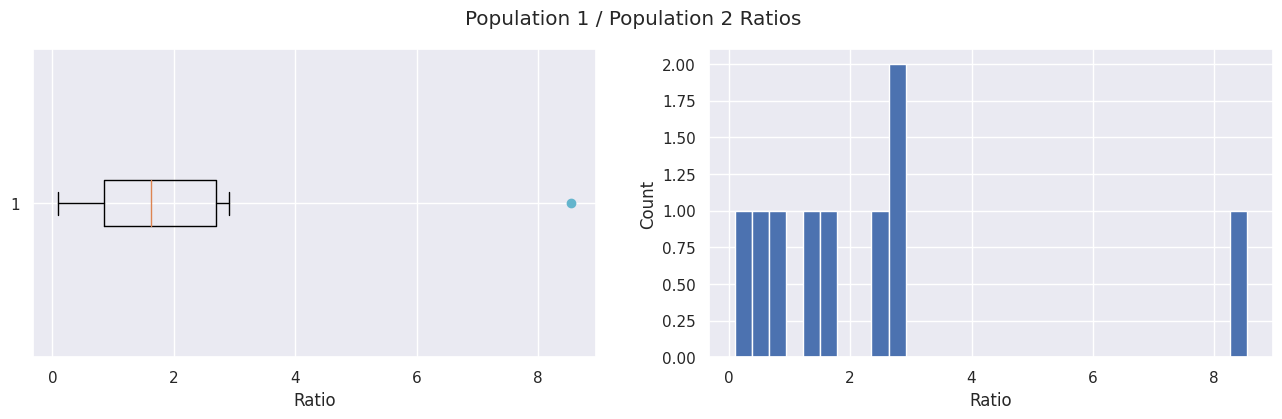

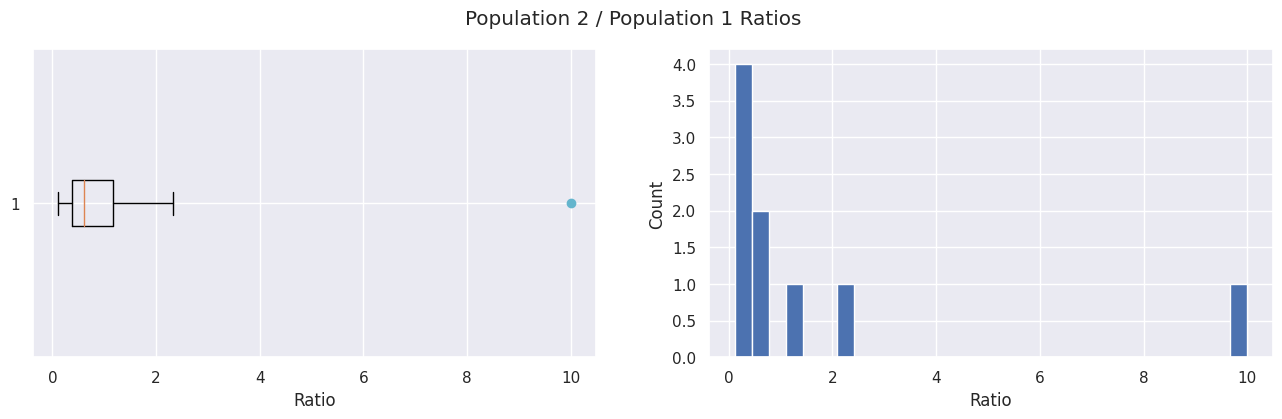

In [7]:
misc_utils.verify_in_list(provided_cell_populations=population_1_cells + population_2_cells, 
                          cell_populations_in_fov=all_data[settings.CELL_TYPE].unique())

ratios = compute_cell_ratios(
    cell_neighbors_dir, population_1_cells, population_2_cells, fov_list=all_fovs, bin_number=bins)

## 3. Calculate mixing scores
This will compute the mixing score for each FOV and save the output in the `mixing_score_dir`. 
- `p1_ratio`: the maximun ratio of population 1 / population 2 cells in a FOV required to be assigned a mixing score, **(usually <=5)**
- `p2_ratio`: the maximun ratio of population 2 / population 1 cells in a FOV required to be assigned a mixing score, **(usually <=5)**
- `cell_count_threshold`: the minimum number of cells in each population in a FOV required to be assigned a mixing score

In [ ]:
p1_ratio = 3
p2_ratio = 3
cell_count_threshold = 50

file_name = "CD4_CD8-mixing_score.csv"

<AxesSubplot: xlabel='mixing_score', ylabel='Count'>

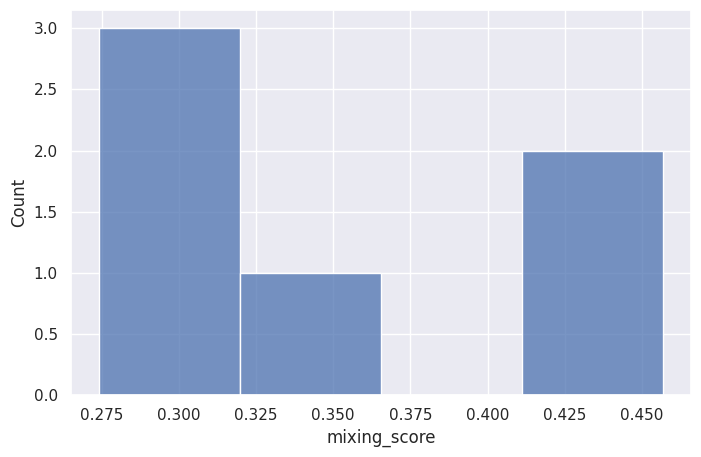

In [9]:
scores = []
for fov in all_fovs:
    fov_score = compute_mixing_score(cell_neighbors_dir, fov, population_1_cells, population_2_cells, 
                                     p1_ratio, p2_ratio, cell_count_threshold)
    scores.append(fov_score)
    
mixing_score_data = pd.DataFrame(list(zip(all_fovs, scores)), columns =['fov', 'mixing_score'])
mixing_score_data = mixing_score_data.merge(ratios, on=['fov'])
mixing_score_data.to_csv(os.path.join(mixing_score_dir, file_name), index=False)

seaborn.set(rc={'figure.figsize':(8,5)})
seaborn.histplot(mixing_score_data, x='mixing_score')